# QUESTION 1.2.2

## IMPORTS & SETUP

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, gamma, poisson

# Load data
data = np.loadtxt("premier_league_2013_2014.dat", delimiter=",")
y_g1 = data[:, 0]
y_g2 = data[:, 1]
h_g = data[:, 2].astype(int)
a_g = data[:, 3].astype(int)

# Constants
n_teams = 20
tau_0 = 0.0001
tau_1 = 0.0001
alpha = beta = 0.1

att_start_idx = 1
def_start_idx = att_start_idx + (n_teams - 1)
hyper_start_idx = def_start_idx + (n_teams - 1)
n_params = 1 + 2 * (n_teams - 1) + 4

## Log-likelihood and log-prior helper functions

In [19]:


def log_likelihood(params):
    home = params[0]
    att = np.zeros(n_teams)
    att[1:] = params[att_start_idx:def_start_idx]
    def_ = np.zeros(n_teams)
    def_[1:] = params[def_start_idx:hyper_start_idx]
    mu_att, mu_def = params[hyper_start_idx], params[hyper_start_idx + 1]
    tau_att, tau_def = params[hyper_start_idx + 2], params[hyper_start_idx + 3]
    if tau_att <= 0 or tau_def <= 0:
        return -np.inf
    log_theta1 = home + att[h_g] - def_[a_g]
    log_theta2 = att[a_g] - def_[h_g]
    theta1, theta2 = np.exp(log_theta1), np.exp(log_theta2)
    ll = np.sum(poisson.logpmf(y_g1, theta1) + poisson.logpmf(y_g2, theta2))
    ll += norm.logpdf(home, 0, np.sqrt(1 / tau_0))
    ll += np.sum(norm.logpdf(att[1:], mu_att, np.sqrt(1 / tau_att)))
    ll += np.sum(norm.logpdf(def_[1:], mu_def, np.sqrt(1 / tau_def)))
    ll += norm.logpdf(mu_att, 0, np.sqrt(1 / tau_1)) + norm.logpdf(mu_def, 0, np.sqrt(1 / tau_1))
    ll += gamma.logpdf(tau_att, alpha, scale=1 / beta) + gamma.logpdf(tau_def, alpha, scale=1 / beta)
    return ll

## MCMC function

In [20]:
def metropolis_hastings(n_burn, n_samples, thin, sigma):
    current = np.zeros(n_params)
    current[hyper_start_idx + 2] = 1.0
    current[hyper_start_idx + 3] = 1.0
    current_ll = log_likelihood(current)
    accepted = 0
    samples = np.zeros((n_samples, n_params))
    home_trace = []

    for i in range(n_burn + n_samples * thin):
        proposal = current + np.random.normal(0, sigma, n_params)
        proposal[hyper_start_idx + 2:] = np.abs(proposal[hyper_start_idx + 2:])
        prop_ll = log_likelihood(proposal)
        log_accept_ratio = prop_ll - current_ll
        if np.log(np.random.rand()) < log_accept_ratio:
            current, current_ll = proposal, prop_ll
            accepted += 1
        if i >= n_burn and (i - n_burn) % thin == 0:
            idx = (i - n_burn) // thin
            samples[idx] = current
            home_trace.append(current[0])
    return samples, np.array(home_trace), accepted / (n_burn + n_samples * thin)

## Running the code

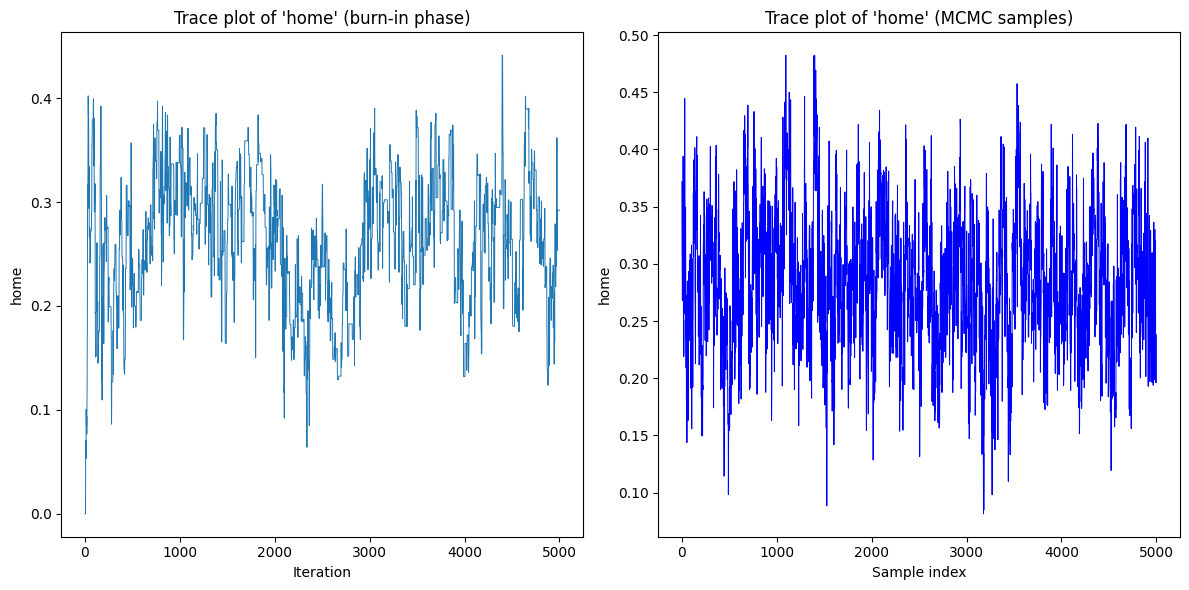

Acceptance rate: 18.48%
Posterior mean of 'home': 0.2836


In [24]:
# Parameters for the run
n_burn = 5000
n_samples = 5000
thin = 5
sigma = 0.05

# Run the MCMC
samples, home_trace, acceptance_rate = metropolis_hastings(n_burn, n_samples, thin, sigma)

# Optional: capture home during burn-in too
def get_burnin_trace(n_burn, sigma):
    current = np.zeros(n_params)
    current[hyper_start_idx + 2] = 1.0
    current[hyper_start_idx + 3] = 1.0
    current_ll = log_likelihood(current)
    trace = []
    for i in range(n_burn):
        proposal = current + np.random.normal(0, sigma, n_params)
        proposal[hyper_start_idx + 2:] = np.abs(proposal[hyper_start_idx + 2:])
        prop_ll = log_likelihood(proposal)
        log_accept_ratio = prop_ll - current_ll
        if np.log(np.random.rand()) < log_accept_ratio:
            current, current_ll = proposal, prop_ll
        trace.append(current[0])
    return np.array(trace)

burnin_trace = get_burnin_trace(n_burn, sigma)

# Plot the trace plots
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot burn-in phase
plt.subplot(1, 2, 1)
plt.plot(range(n_burn), burnin_trace, linewidth=0.7)
plt.title("Trace plot of 'home' (burn-in phase)")
plt.xlabel("Iteration")
plt.ylabel("home")

# Plot sampling phase
plt.subplot(1, 2, 2)
plt.plot(range(n_samples), home_trace, linewidth=0.7, color='blue')
plt.title("Trace plot of 'home' (MCMC samples)")
plt.xlabel("Sample index")
plt.ylabel("home")

plt.tight_layout()
plt.savefig("home_trace_burnin_and_sampling.png")
plt.show()

# Summary
print(f"Acceptance rate: {acceptance_rate:.2%}")
print(f"Posterior mean of 'home': {np.mean(home_trace):.4f}")


## Posterior samples of Home

Posterior mean of home: 0.2836
Posterior std. dev of home: 0.0591


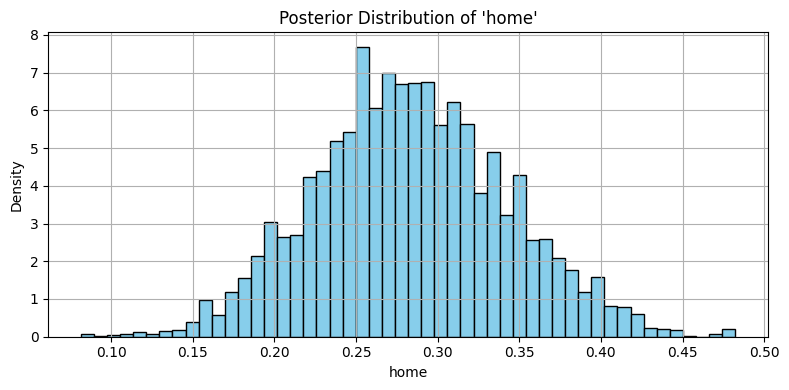

In [25]:
mean_home = np.mean(home_trace)
std_home = np.std(home_trace)

print(f"Posterior mean of home: {mean_home:.4f}")
print(f"Posterior std. dev of home: {std_home:.4f}")
# Plot histogram of home parameter

plt.figure(figsize=(8, 4))
plt.hist(home_trace, bins=50, color='skyblue', edgecolor='k', density=True)
plt.title("Posterior Distribution of 'home'")
plt.xlabel("home")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.savefig("posterior_home_hist.png")
plt.show()


## Scatter plot of attack vs defense for teams (posterior means):

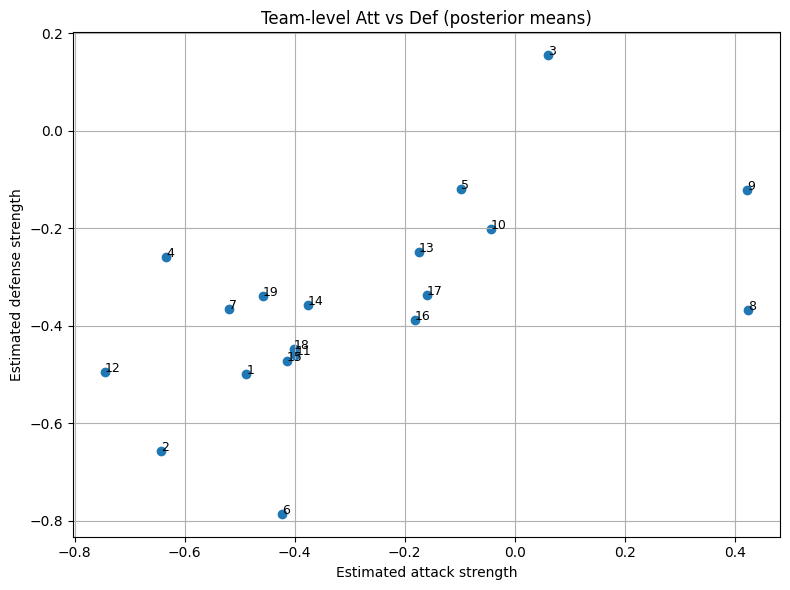

In [26]:
att_samples = samples[:, att_start_idx:def_start_idx]
def_samples = samples[:, def_start_idx:hyper_start_idx]

mean_att = att_samples.mean(axis=0)
mean_def = def_samples.mean(axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(mean_att, mean_def)

for i in range(1, n_teams):
    plt.text(mean_att[i-1], mean_def[i-1], str(i), fontsize=9)

plt.xlabel("Estimated attack strength")
plt.ylabel("Estimated defense strength")
plt.title("Team-level Att vs Def (posterior means)")
plt.grid(True)
plt.tight_layout()
plt.savefig('att_vs_def.png')
plt.show()


## Bonus Question

Running σ=0.005, t=1
Running σ=0.005, t=5
Running σ=0.005, t=20
Running σ=0.005, t=50
Running σ=0.05, t=1
Running σ=0.05, t=5
Running σ=0.05, t=20
Running σ=0.05, t=50
Running σ=0.5, t=1
Running σ=0.5, t=5
Running σ=0.5, t=20
Running σ=0.5, t=50


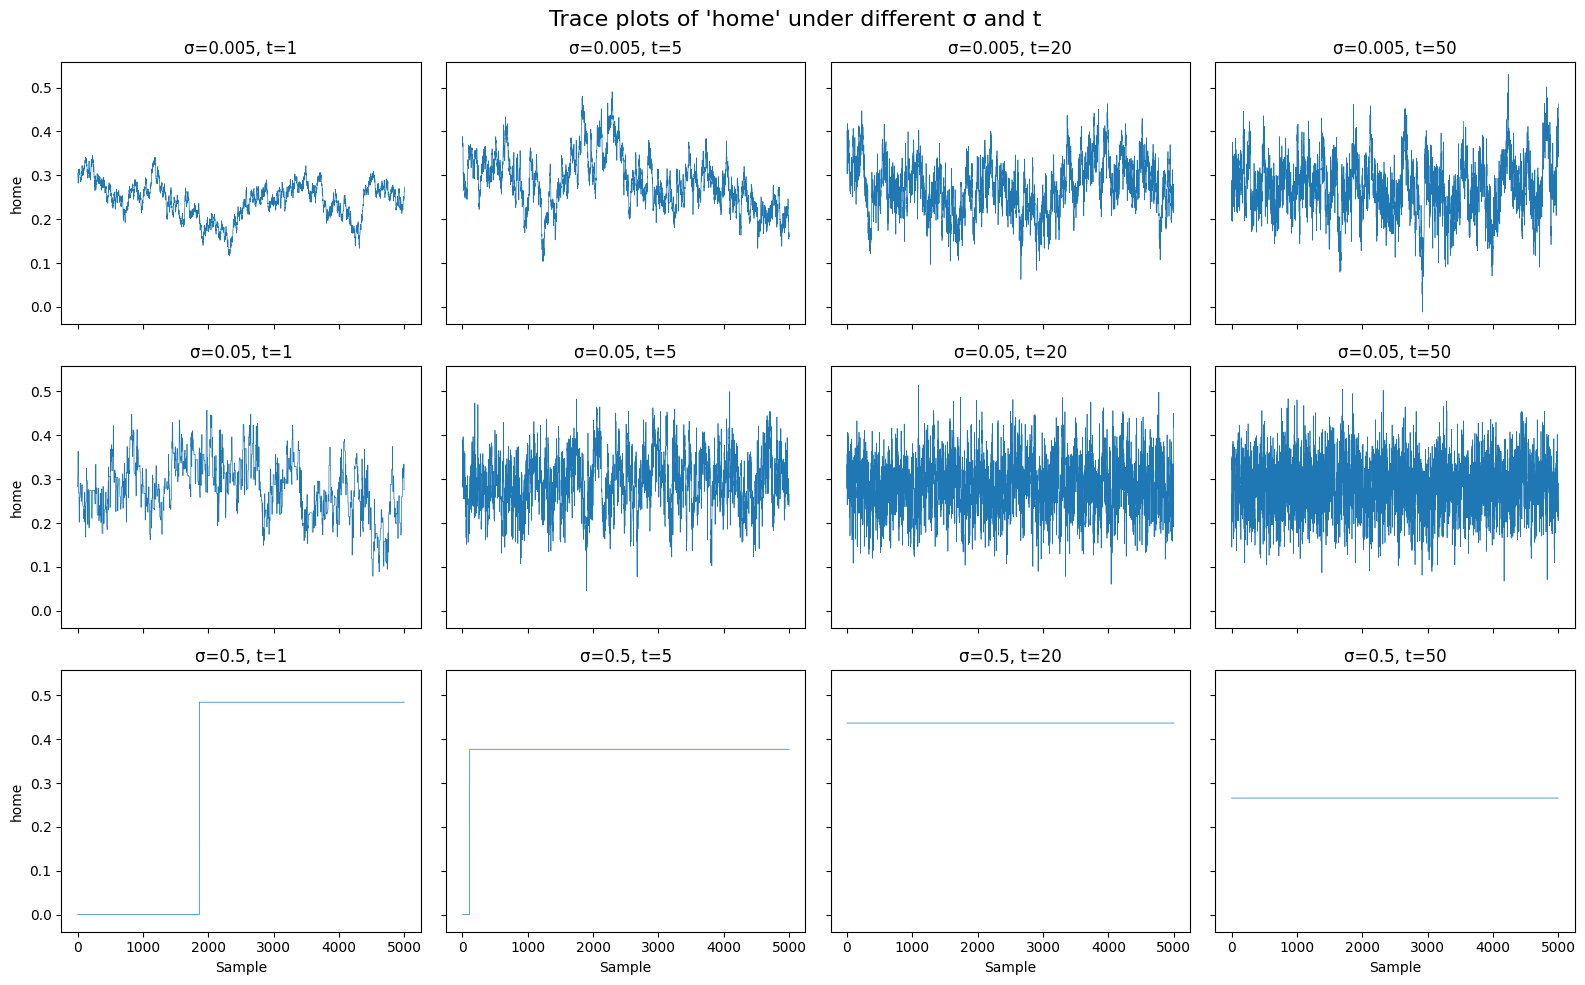


Acceptance Rate Table:

        σ   t  Acceptance Rate (%)
0   0.005   1                88.34
1   0.005   5                89.24
2   0.005  20                89.56
3   0.005  50                89.38
4   0.050   1                19.82
5   0.050   5                18.93
6   0.050  20                18.43
7   0.050  50                16.77
8   0.500   1                 0.01
9   0.500   5                 0.00
10  0.500  20                 0.00
11  0.500  50                 0.00


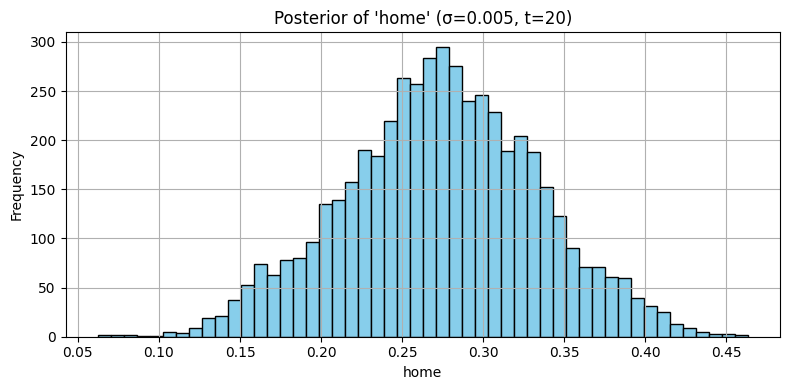

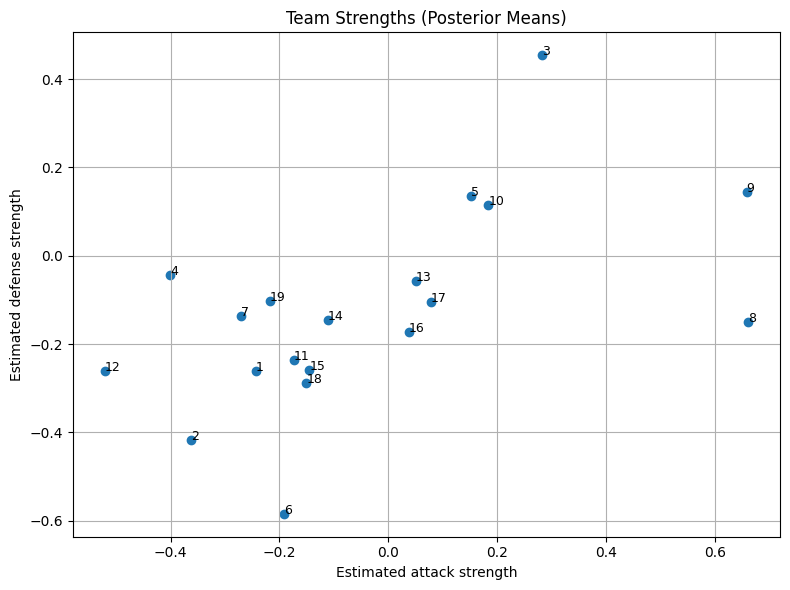

In [21]:

# Run for various σ and thinning t
sigmas = [0.005, 0.05, 0.5]
thins = [1, 5, 20, 50]
n_burn, n_samples = 5000, 5000
results = []

for sigma in sigmas:
    for t in thins:
        print(f"Running σ={sigma}, t={t}")
        samples, home_trace, acc_rate = metropolis_hastings(n_burn, n_samples, t, sigma)
        results.append({
            "σ": sigma, "t": t,
            "acceptance": acc_rate,
            "samples": samples,
            "home_trace": home_trace
        })

# Plot trace plots grid
fig, axes = plt.subplots(len(sigmas), len(thins), figsize=(16, 10), sharex=True, sharey=True)
for i, sigma in enumerate(sigmas):
    for j, t in enumerate(thins):
        idx = i * len(thins) + j
        axes[i, j].plot(results[idx]["home_trace"], linewidth=0.5)
        axes[i, j].set_title(f"σ={sigma}, t={t}")
        if i == len(sigmas) - 1: axes[i, j].set_xlabel("Sample")
        if j == 0: axes[i, j].set_ylabel("home")
plt.suptitle("Trace plots of 'home' under different σ and t", fontsize=16)
plt.tight_layout()
plt.savefig("bonus_trace_grid.png")
plt.show()

# Print acceptance rate table
acceptance_table = pd.DataFrame([{
    "σ": r["σ"], "t": r["t"], "Acceptance Rate (%)": round(r["acceptance"] * 100, 2)
} for r in results])
print("\nAcceptance Rate Table:\n")
print(acceptance_table)

# Select best setting (highest acceptance)
best = max(results, key=lambda r: r["acceptance"])

# Plot posterior histogram of 'home'
plt.figure(figsize=(8, 4))
plt.hist(best["home_trace"], bins=50, color='skyblue', edgecolor='k')
plt.title(f"Posterior of 'home' (σ={best['σ']}, t={best['t']})")
plt.xlabel("home")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("bonus_home_hist.png")
plt.show()

# Plot att vs def means
att_samples = best["samples"][:, att_start_idx:def_start_idx]
def_samples = best["samples"][:, def_start_idx:hyper_start_idx]
mean_att = att_samples.mean(axis=0)
mean_def = def_samples.mean(axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(mean_att, mean_def)
for i in range(1, n_teams):
    plt.text(mean_att[i - 1], mean_def[i - 1], str(i), fontsize=9)
plt.xlabel("Estimated attack strength")
plt.ylabel("Estimated defense strength")
plt.title("Team Strengths (Posterior Means)")
plt.grid(True)
plt.tight_layout()
plt.savefig("bonus_att_vs_def.png")
plt.show()


# Question 2

Posterior mean of x | y=1: 0.56526
Posterior variance of x | y=1: 0.68073


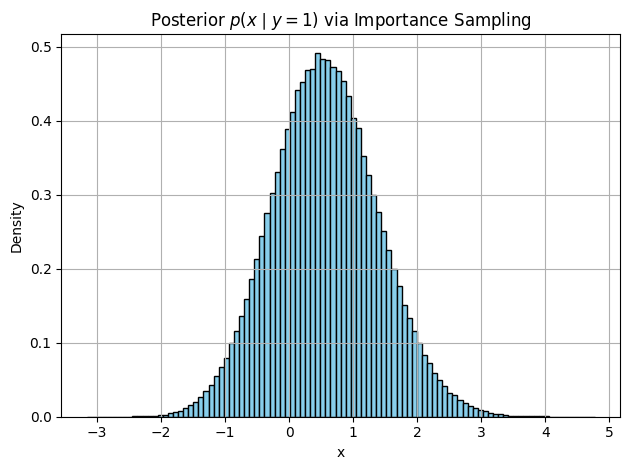

In [30]:
import numpy as np
import matplotlib.pyplot as plt

N = 1_000_000

# Correctly sample x and v
x = np.random.normal(0, 1, N)
v = np.random.normal(0, 1, N)

# t = x + v → t ~ N(0, 2)
t = x + v

# Condition on y = 1 ⇔ t > 0
x_given_y1 = x[t > 0]

# Empirical stats
mean_x = np.mean(x_given_y1)
var_x = np.var(x_given_y1)

print(f"Posterior mean of x | y=1: {mean_x:.5f}")
print(f"Posterior variance of x | y=1: {var_x:.5f}")

# Plot
plt.hist(x_given_y1, bins=100, density=True, color='skyblue', edgecolor='k')
plt.title("Posterior $p(x \\mid y=1)$ via Importance Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.savefig("posterior_importance_sampling.png")
plt.show()
